## 🌱 Plant Disease Classification Using Deep Learning

This project leverages deep learning techniques to automatically identify plant diseases from leaf images using the PlantVillage dataset. The workflow highlights essential stages of contemporary image classification, including data preprocessing, augmentation, model training with MobileNetV2, fine-tuning, and performance evaluation. The primary objective is to develop an accurate and accessible diagnostic tool for crop disease detection.

## 📂 Inspecting Dataset Classes

I will list the folders in the PlantVillage dataset because I want to verify that all disease classes are present and the dataset is structured correctly before moving forward.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

dataset_path = 'PlantVillage'
print("Classes in dataset:")
print(os.listdir(dataset_path))

Classes in dataset:
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


## 🖼️ Visualizing Sample Images

I will display a few sample images from one class in the PlantVillage dataset because I want to visually confirm that the images are loading correctly and to get an idea of the data quality and variety.

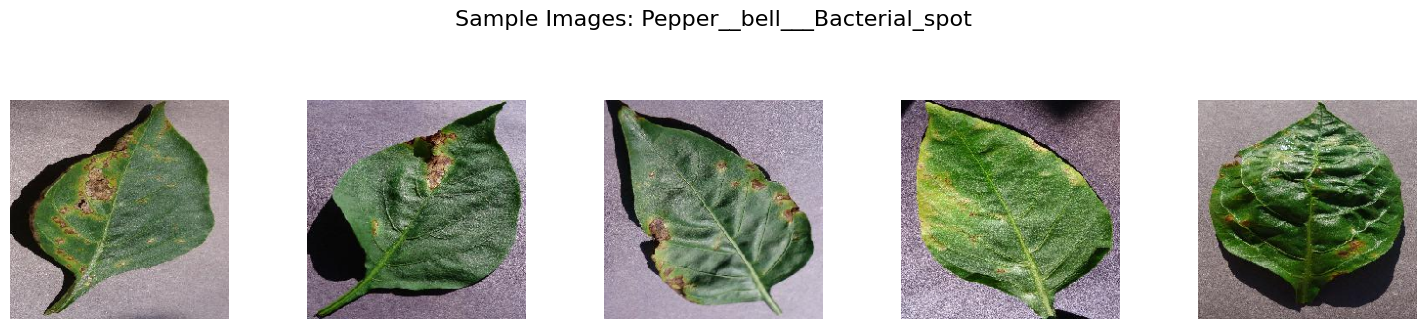

In [2]:
import matplotlib.pyplot as plt
from keras._tf_keras.keras.preprocessing import image
import os

class_name = os.listdir(dataset_path)[0]
class_folder = os.path.join(dataset_path, class_name)
sample_images = os.listdir(class_folder)[:5]

plt.figure(figsize=(15, 3))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(class_folder, img_name)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle(f'Sample Images: {class_name}', y=1.08, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 🛠️ Configuring Data Augmentation & Generators  
I will create augmented training data and split the dataset into training/validation sets because I want to:  
- **Improve generalization** with rotations, flips, brightness changes, and other transformations  
- Reserve 20% of data (`validation_split=0.2`) for model evaluation  
- Process images in batches of 32 (`batch_size=32`) at 224x224 resolution

In [3]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = val_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


## 🧠 Building the MobileNetV2 Base Model  
I will:  
- Use **MobileNetV2** pretrained on ImageNet (with `include_top=False`)  
- Freeze its layers (`base_model.trainable=False`) to preserve learned features  
- Add new classification layers (GlobalAveragePooling → Dense(128) → Dropout → Output)  
- Compile with Adam optimizer (learning_rate=0.0001) and categorical crossentropy loss  

Because I want to:  
- Leverage transfer learning for better performance  
- Prevent overfitting with dropout regularization  
- Create a lightweight yet powerful model for disease classification 

In [4]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## ⚙️ Training Configuration & Execution  
I will:  
- Use **EarlyStopping** to halt training if val_loss doesn't improve for 8 epochs  
- Compute **class weights** to handle imbalanced data (`class_weight='balanced'`)  
- Train for 100 epochs with batch_size=32  

Because I want to:  
- Prevent overfitting while preserving best weights  
- Ensure minority disease classes get adequate attention during training  
- Balance training duration and model performance

In [5]:
from keras.src.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 610s 1s/step - accuracy: 0.2099 - loss: 2.5873 - val_accuracy: 0.6322 - val_loss: 1.3671
Epoch 2/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 367s 709ms/step - accuracy: 0.5470 - loss: 1.4315 - val_accuracy: 0.7380 - val_loss: 0.9584
Epoch 3/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 367s 710ms/step - accuracy: 0.6396 - loss: 1.1044 - val_accuracy: 0.7559 - val_loss: 0.8283
Epoch 4/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 367s 710ms/step - accuracy: 0.6951 - loss: 0.9529 - val_accuracy: 0.7897 - val_loss: 0.7159
Epoch 5/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 365s 706ms/step - accuracy: 0.7139 - loss: 0.8659 - val_accuracy: 0.8142 - val_loss: 0.6324
Epoch 6/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 368s 712ms/step - accuracy: 0.7283 - loss: 0.8170 - val_accuracy: 0.8166 - val_loss: 0.6083
Epoch 7/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 366s 707ms/step - accuracy: 0.7429 - loss: 0.7549 - val_accuracy: 0.8188 - val_loss: 0.5885
Epoch 8/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 381s 705ms/step - accuracy: 0.7

## 🚀 Fine-Tuning MobileNetV2 for Enhanced Accuracy  
I will:  
- **Unfreeze the last 50 layers** of MobileNetV2  
- **Lower the learning rate** to 1e-5 for gentle weight adjustments  
- Train for **20 additional epochs**  

Because I want to:  
- Adapt pretrained features to our specific plant disease dataset  
- Avoid overfitting by keeping early convolutional layers frozen  
- Incrementally improve accuracy without disrupting foundational patterns

In [6]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 20
total_epochs = len(history.history['accuracy']) + fine_tune_epochs

history_finetune = model.fit(
    train_gen,
    epochs=total_epochs,
    initial_epoch=len(history.history['accuracy']),
    validation_data=val_gen,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 99/118
517/517 ━━━━━━━━━━━━━━━━━━━━ 448s 855ms/step - accuracy: 0.5781 - loss: 1.9187 - val_accuracy: 0.8481 - val_loss: 0.4617
Epoch 100/118
517/517 ━━━━━━━━━━━━━━━━━━━━ 483s 935ms/step - accuracy: 0.7783 - loss: 0.6383 - val_accuracy: 0.8564 - val_loss: 0.4441
Epoch 101/118
517/517 ━━━━━━━━━━━━━━━━━━━━ 427s 825ms/step - accuracy: 0.8180 - loss: 0.5141 - val_accuracy: 0.8697 - val_loss: 0.3905
Epoch 102/118
517/517 ━━━━━━━━━━━━━━━━━━━━ 425s 822ms/step - accuracy: 0.8373 - loss: 0.4561 - val_accuracy: 0.8857 - val_loss: 0.3450
Epoch 103/118
517/517 ━━━━━━━━━━━━━━━━━━━━ 421s 814ms/step - accuracy: 0.8612 - loss: 0.3848 - val_accuracy: 0.8908 - val_loss: 0.3258
Epoch 104/118
517/517 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.8722 - loss: 0.3519 - val_accuracy: 0.9042 - val_loss: 0.2821
Epoch 105/118
517/517 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - accuracy: 0.8826 - loss: 0.3197 - val_accuracy: 0.9061 - val_loss: 0.2664
Epoch 106/118
517/517 ━━━━━━━━━━━━━━━━━━━━ 13223s 26s/step - a

## 📊 Visualizing Training Progress

I will plot the training and validation accuracy and loss curves because I want to:
- Monitor how well the model is learning over epochs
- Check for signs of overfitting or underfitting
- Visually compare training and validation performance

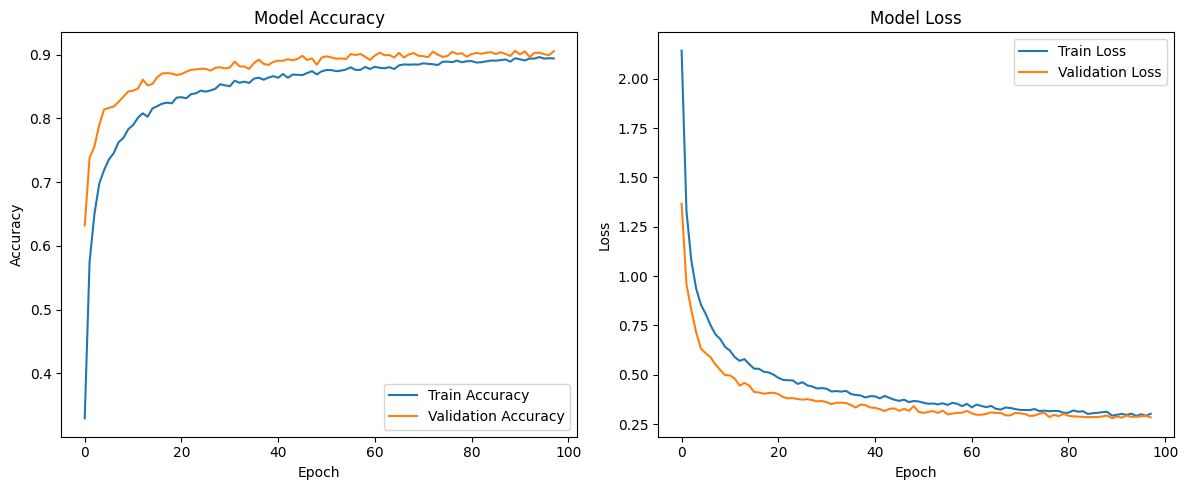

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 💾 Saving the Model

I will save the model because I want to use it in the crop disease identification UI.

In [8]:
model.save('crop_disease_model.keras')

## 🙏 Acknowledgment

Thank you for exploring this project! Special thanks to the creators of the PlantVillage dataset and the open-source community for providing the tools and resources that made this work possible.

## 📝 Next Steps for You

- Try uploading your own leaf images in the crop disease identification UI to see the model in action.
- Instructions for using the UI are provided in the README file.
- Experiment with different images, lighting conditions, or plant types to test the model’s robustness.
- If you’re interested, you can further fine-tune the model or try other deep learning architectures for even higher accuracy.
- Feel free to use or adapt this notebook for your own plant disease detection projects!